# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# 1. Installing Dependencies

In [1]:
!pip install matplotlib
!pip install imblearn

     |████████████████████████████████| 199 kB 25.4 MB/s            
     |████████████████████████████████| 189 kB 65.8 MB/s            


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import math
import json
plt.rc("font", size=14)
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import collections
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# 2. Loading the datasets

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2.1 Portfolio Dataset

In [4]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# Here we create dummies for different channels in portfolio dataset

portfolio['email'] = portfolio.channels.apply(lambda x: 1 if "email" in x else 0)
portfolio['mobile'] = portfolio.channels.apply(lambda x: 1 if "mobile" in x else 0)
portfolio['web'] = portfolio.channels.apply(lambda x: 1 if "web" in x else 0)
portfolio['social'] = portfolio.channels.apply(lambda x: 1 if "social" in x else 0)

In [6]:
portfolio= portfolio.rename(columns={'id': 'offer_id'})
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,web,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [7]:
portfolio.describe()

,reward,difficulty,duration,email,mobile,web,social
count,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
mean,4.20000,7.70000,6.50000,1.00000,0.90000,0.80000,0.60000
std,3.58391,5.83190,2.32140,0.00000,0.31623,0.42164,0.51640
min,0.00000,0.00000,3.00000,1.00000,0.00000,0.00000,0.00000
25%,2.00000,5.00000,5.00000,1.00000,1.00000,1.00000,0.00000
50%,4.00000,8.50000,7.00000,1.00000,1.00000,1.00000,1.00000
75%,5.00000,10.00000,7.00000,1.00000,1.00000,1.00000,1.00000
max,10.00000,20.00000,10.00000,1.00000,1.00000,1.00000,1.00000


We see from above that the portfolio dataset has information on various offers including things like reward, difficulty, duration (offer validity period in days) and the channels through which the offer is communicated.

All the offers are commicated via email and around 90% and 80% of them are communicated via mobile and web respectively. Social media communication is least popular and only around 60% of the available offers are communicated through this platform

## 2.2 Profile Dataset

In [8]:
profile.head(100)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,nan
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.00000
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,nan
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.00000
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,nan
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.00000
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,nan
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,nan
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.00000
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,nan


We see from above that the Profile dataset has information on different customers including their age, gender, became_member_on and their income.

We run some basic tests to check how many entries belong to missing number categories.

In [9]:
profile[profile.isnull().any(axis=1)]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,nan
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,nan
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,nan
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,nan
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,nan
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,nan
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,nan
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,nan
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,nan


We see that the profile dataset has 2175 entries with null values in atleast one of the gender, age or income fields. 
The default value of age is 118.

We will be imputing age and income fields with mean of their values and we will create a new gender class to accommodate the null entries.

In [10]:
median_age = profile.query('age != 118').age.median()
median_income = profile.query('income != "nan"').income.median()

print("The median age is "+ str(median_age)+" and the median income is "+str(median_income))

The median age is 55.0 and the median income is 64000.0


In [11]:
# Fill missing genders with 'O' and nan income with median_income

#Fill rows with age == 118 with the median income
profile.fillna({'gender' : 'O', 'income':median_income }, inplace= True)
profile = profile.replace({'age':118}, median_age)

In [12]:
profile.head(100)

,gender,age,id,became_member_on,income
0,O,55,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.00000
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.00000
2,O,55,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.00000
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.00000
4,O,55,a03223e636434f42ac4c3df47e8bac43,20170804,64000.00000
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.00000
6,O,55,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,64000.00000
7,O,55,68617ca6246f4fbc85e91a2a49552598,20171002,64000.00000
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.00000
9,O,55,8974fc5686fe429db53ddde067b88302,20161122,64000.00000


array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='income', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='income'>,
        <AxesSubplot:xlabel='income', ylabel='income'>]], dtype=object)

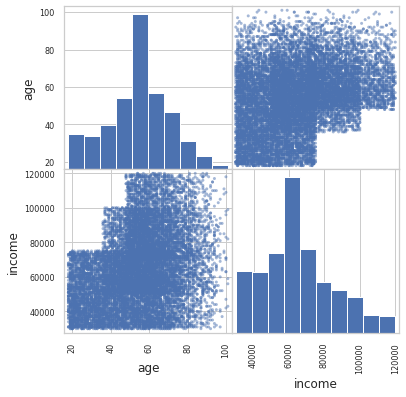

In [13]:
pd.plotting.scatter_matrix(profile[['age','income']], figsize = (6,6))

From the scatter matrix above, we conclude that age and income are both approximately symmetrically distributed. The average income is higher for larger age groups   

In [14]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
print(profile['became_member_on'].max())


2018-07-26 00:00:00


In [15]:
# we see that the latest date available is 26th July 2018 so we will base our analysis on July Month End 2018

profile['days_as_member'] =  profile['became_member_on'].apply(lambda x: pd.Timestamp('2018-07-31')-x ).dt.days

In [16]:
profile= profile.rename(columns={'id': 'customer_id'})
profile.head(100)

,gender,age,customer_id,became_member_on,income,days_as_member
0,O,55,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.00000,534
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00000,381
2,O,55,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.00000,19
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00000,448
4,O,55,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.00000,361
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.00000,96
6,O,55,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,64000.00000,309
7,O,55,68617ca6246f4fbc85e91a2a49552598,2017-10-02,64000.00000,302
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.00000,172
9,O,55,8974fc5686fe429db53ddde067b88302,2016-11-22,64000.00000,616


## 2.3 Transcript Dataset

In [17]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


The transcript dataset has information on different events for the customers. These events either refer to a received offer, viewed offer, transaction or completed offer. We have a value column for every event logged in the transcript. The value column contains information on `offer_id` for offer based events (offer viewed, offer received or offer completed) and it has information on `amount` for transaction based events.

We will be seperating these two datasets later for Data Processing and Feature ENgineering.

In [18]:
# First we extract the information from value column in transcript dataset by using pd.json
# Note that offer_id and offer id are identical information with different keys so we will be renaming them 

# Flatten the value column
transcript_normalised = pd.json_normalize(transcript.value)
#Unify the offer_id fields
transcript_normalised['offer_id'] = transcript_normalised['offer id'].fillna('') + transcript_normalised['offer_id'].fillna('')
#concatenate and drop the unnecessary columns
transcript = pd.concat([transcript, transcript_normalised], axis = 1)
transcript.drop(['value', 'offer id'], axis =1, inplace = True) 
transcript= transcript.rename(columns={'person': 'customer_id'})

In [19]:
transcript

,customer_id,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,nan,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,nan,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan
2,e2127556f4f64592b11af22de27a7932,offer received,0,nan,2906b810c7d4411798c6938adc9daaa5,nan
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,nan,fafdcd668e3743c1bb461111dcafc2a4,nan
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,nan,4d5c57ea9a6940dd891ad53e9dbe8da0,nan
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59000,,nan
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53000,,nan
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61000,,nan
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53000,,nan


In [20]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

We see from above that the time for which the test was conducted in hours is starting from 0 and progressing in increments of 6 all the way up to 714. From here we conclude that the testing happened for around 6 hours per day for 120 days. 

Next we introduce additional columns for days and months based on this inference. We will analyse the sales and transaction information on daily and monthly basis using the additional attributes inserted. We also append the offer_types against the event logs.

In [21]:
transcript['days'] = transcript['time']/6 +1 
transcript['days'] = transcript['days'].astype(int)

transcript['months'] = (transcript['days']-1)//30 +1
transcript['months'] = transcript['months'].astype(int)

transcript = transcript.merge(portfolio[['offer_type', 'offer_id']], left_on = 'offer_id', right_on = 'offer_id', how ='left' )

In [22]:
transcript

,customer_id,event,time,amount,offer_id,reward,days,months,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,nan,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,1,1,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,nan,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,1,1,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,nan,2906b810c7d4411798c6938adc9daaa5,nan,1,1,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,nan,fafdcd668e3743c1bb461111dcafc2a4,nan,1,1,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,nan,4d5c57ea9a6940dd891ad53e9dbe8da0,nan,1,1,bogo
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59000,,nan,120,4,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53000,,nan,120,4,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61000,,nan,120,4,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53000,,nan,120,4,NaN


Now we seperate the transcript dataset into offer based and transaction based datasets. The offer based dataset has information on offer received, offer viewed and offer completed events and transaction based dataset has information on transactions conducted. Note that transactions conducted lead to the offer completion so that way the two datasets are linked.

We also show a sample of the datasets for a particular customer. 

In [23]:
transcript_offer = transcript.query('event != "transaction"')
transcript_offer.drop(['amount'], axis = 1, inplace=True)

transcript_transaction = transcript.query('event == "transaction"')
transcript_transaction.drop(['offer_id'], axis = 1, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
transcript_offer

,customer_id,event,time,offer_id,reward,days,months,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,1,1,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,1,1,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,nan,1,1,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,nan,1,1,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,nan,1,1,bogo
...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3.00000,120,4,discount
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.00000,120,4,discount
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,120,4,discount
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.00000,120,4,discount


In [25]:
transcript_transaction

,customer_id,event,time,amount,reward,days,months,offer_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83000,nan,1,1,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56000,nan,1,1,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23000,nan,1,1,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51000,nan,1,1,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97000,nan,1,1,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59000,nan,120,4,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53000,nan,120,4,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61000,nan,120,4,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53000,nan,120,4,NaN


In [26]:
transcript_offer.query('customer_id == "78afa995795e4d85b5d9ceeca43f5fef"')

,customer_id,event,time,offer_id,reward,days,months,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,1,1,bogo
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,nan,2,1,bogo
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.00000,23,1,bogo
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,nan,29,1,informational
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,nan,37,2,informational
150598,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,ae264e3637204a6fb9bb56bc8210ddfd,nan,69,3,bogo
163375,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,ae264e3637204a6fb9bb56bc8210ddfd,nan,69,3,bogo
201572,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,nan,85,3,bogo
218394,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,ae264e3637204a6fb9bb56bc8210ddfd,10.00000,86,3,bogo
218395,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,f19421c1d4aa40978ebb69ca19b0e20d,5.00000,86,3,bogo


In [27]:
transcript_transaction.query('customer_id == "78afa995795e4d85b5d9ceeca43f5fef"')

,customer_id,event,time,amount,reward,days,months,offer_type
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89000,nan,23,1,NaN
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78000,nan,25,1,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67000,nan,38,2,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72000,nan,41,2,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93000,nan,64,3,NaN
218393,78afa995795e4d85b5d9ceeca43f5fef,transaction,510,21.72000,nan,86,3,NaN
230412,78afa995795e4d85b5d9ceeca43f5fef,transaction,534,26.56000,nan,90,3,NaN


From the two datasets queries above, we conclude that customer `78afa995795e4d85b5d9ceeca43f5fef` received offer `9b98b8c7a33c4b65b9aebfe6a799e6d9` on day 1, viewed the offer on day 2 and conducted a transaction worth 19.89 on day 3 which met the offer difficulty.  This led to offer completion on day 23 and a reward worth 5 units was credit to the customer.

# 3. Data Exploration

In this section, we perform exploration on the datasets obtained above to analyse the following broader themes:

* Customer activity over the test period 


* Total customer sales over the test period


* Customer Demographics as to how different offers are distributed over different demographic metrics like age, income, days of membership, etc.   

Text(0.5, 0.98, 'Customer Activity over Test Period')

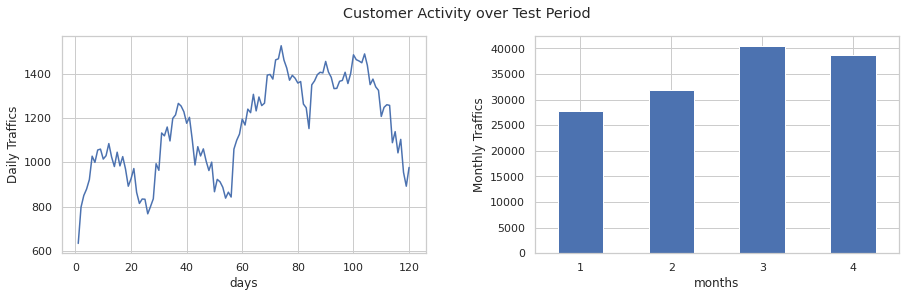

In [28]:
plt.figure(figsize=[15,4]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.5)
base_color =sns.color_palette()[0]

plt.subplot(1, 2, 1)
transcript_transaction.groupby('days')['customer_id'].count().plot(kind ='line')
plt.ylabel('Daily Traffics')

plt.subplot(1, 2, 2)
transcript_transaction.groupby('months')['customer_id'].count().plot(kind ='bar')
plt.ylabel('Monthly Traffics')
plt.xticks(rotation=360)

plt.suptitle('Customer Activity over Test Period')


Text(0.5, 0.98, 'Total Sales Amount over Test Perios')

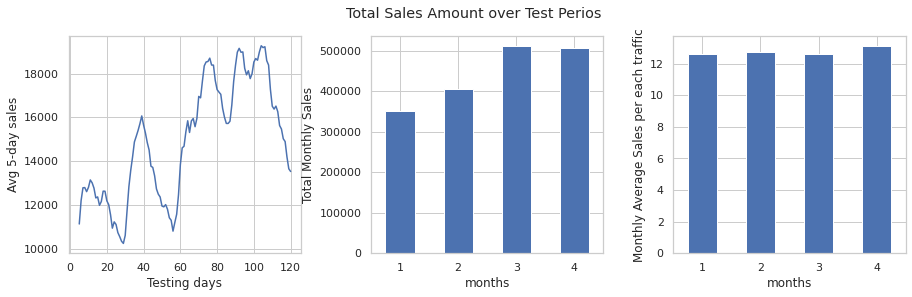

In [29]:
plt.figure(figsize=[15,4]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.5)

plt.subplot(1, 3, 1)
sales = transcript_transaction.groupby('days',  as_index= False)['amount'].sum()
# Compute a 5 - day moving average to reflect the average sales over last 5 days 
sales['5-day Avg'] = sales.iloc[:,1].rolling(window =5).mean()
plt.plot(sales['days'], sales['5-day Avg'])
plt.xlabel('Testing days')
plt.ylabel('Avg 5-day sales')

plt.subplot(1, 3, 2)
transcript_transaction.groupby('months')['amount'].sum().plot(kind ='bar')
plt.xticks(rotation=360)
plt.ylabel('Total Monthly Sales')

plt.subplot(1, 3, 3)
transcript_transaction.groupby('months')['amount'].mean().plot(kind ='bar')
plt.xticks(rotation=360)
plt.ylabel('Monthly Average Sales per each traffic')

plt.suptitle('Total Sales Amount over Test Perios')

From the two plots above, we conclude that customer activity and Total Sales have increased up to first 3 months and has slighly decreased for the fourth month.

Monthly Average Sales have remained mostly flat over the four months. 

In [30]:
issued_offers = pd.concat([transcript_offer, pd.get_dummies(transcript_offer.offer_type)], axis = 1).query('event == "offer received"')

issued_offers  = issued_offers.groupby('customer_id', as_index= False)[['bogo','discount', 'informational']].sum()
issued_offers = issued_offers.merge(profile, left_on = 'customer_id', right_on= 'customer_id', how='left')

In [31]:
issued_offers

,customer_id,bogo,discount,informational,gender,age,became_member_on,income,days_as_member
0,0009655768c64bdeb2e877511632db8f,1,2,2,M,33,2017-04-21,72000.00000,466
1,00116118485d4dfda04fdbaba9a87b5c,2,0,0,O,55,2018-04-25,64000.00000,97
2,0011e0d4e6b944f998e987f904e8c1e5,1,2,2,O,40,2018-01-09,57000.00000,203
3,0020c2b971eb4e9188eac86d93036a77,2,2,1,F,59,2016-03-04,90000.00000,879
4,0020ccbbb6d84e358d3414a3ff76cffd,2,1,1,F,24,2016-11-11,60000.00000,627
...,...,...,...,...,...,...,...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,1,3,2,F,69,2015-09-20,83000.00000,1045
16990,fff7576017104bcc8677a8d63322b5e1,3,2,0,M,71,2017-10-31,73000.00000,273
16991,fff8957ea8b240a6b5e634b6ee8eafcf,1,1,1,M,71,2018-02-18,56000.00000,163
16992,fffad4f4828548d1b5583907f2e9906b,3,0,1,M,34,2017-01-23,34000.00000,554


In [32]:
issued_offers.describe()

,bogo,discount,informational,age,income,days_as_member
count,16994.00000,16994.00000,16994.00000,16994.00000,16994.00000,16994.00000
mean,1.79469,1.79728,0.89649,54.46722,65226.90361,522.44169
std,1.12018,1.13094,0.87496,16.23446,20174.69613,411.26623
min,0.00000,0.00000,0.00000,18.00000,30000.00000,5.00000
25%,1.00000,1.00000,0.00000,45.00000,51000.00000,213.00000
50%,2.00000,2.00000,1.00000,55.00000,64000.00000,363.00000
75%,3.00000,3.00000,1.00000,65.00000,76000.00000,796.00000
max,6.00000,6.00000,5.00000,101.00000,120000.00000,1828.00000


Text(0.5, 1.0, 'Informational')

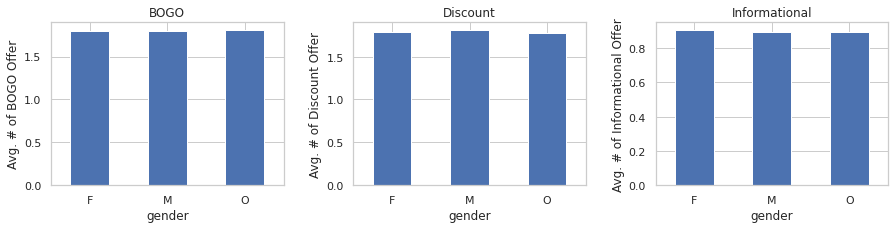

In [33]:
plt.figure(figsize=[15,3]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.5)
gender_order = issued_offers.gender.value_counts()

plt.subplot(1, 3, 1)
issued_offers.groupby('gender')['bogo'].mean().plot(kind ='bar')
plt.xticks(rotation=360)
plt.ylabel('Avg. # of BOGO Offer') 
plt.title('BOGO')

plt.subplot(1, 3, 2)
issued_offers.groupby('gender')['discount'].mean().plot(kind ='bar')
plt.xticks(rotation=360)
plt.ylabel('Avg. # of Discount Offer') 
plt.title('Discount')

plt.subplot(1, 3, 3)
issued_offers.groupby('gender')['informational'].mean().plot(kind ='bar')
plt.xticks(rotation=360)
plt.ylabel('Avg. # of Informational Offer') 
plt.title('Informational')



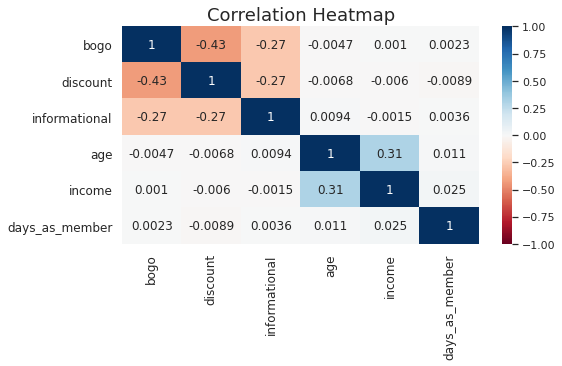

In [34]:
# Correlation in Heatmap form 
plt.figure(figsize=(8,4))
s = sns.heatmap(issued_offers.corr(), annot = True, cmap = 'RdBu', vmin = -1, vmax=1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize =12) 
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize =12) 
plt.title('Correlation Heatmap', fontsize =18)
plt.show()

From the two plots above, we conclude that on a average basis, there is no significant bias in the distribution of offers rolled across various gender tpes. Also the correlation plot above suggests that number of bogo, discount and informational offers rolled are uncorrelated with population demographics like age, income or days since membership.

<AxesSubplot:xlabel='offer_type', ylabel='count'>

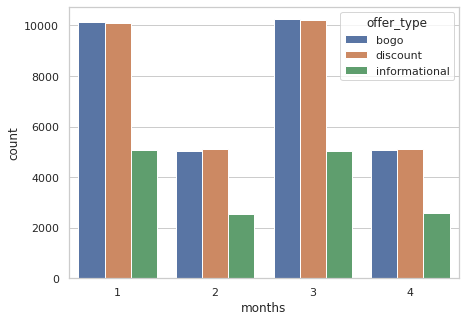

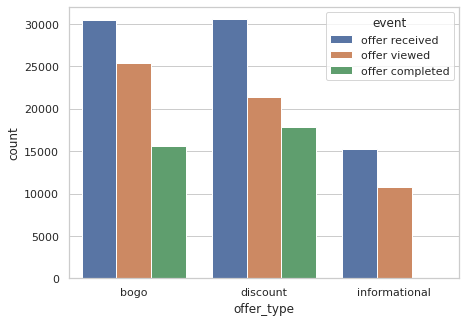

In [35]:
plt.figure(figsize =[7,5])
ax = sns.countplot(data = transcript_offer.query('event=="offer received"'), x = 'months', hue = 'offer_type')

plt.figure(figsize =[7,5])
sns.countplot(data = transcript_offer, x = 'offer_type', hue = 'event')

Finally, from the two plots above, we conclude that bogo and discount offers are rolled in same number for each of the four test months. The number of discount offers rolled are always lower than bogo/informational offers.

A higher proportion of bogo offers are viewed than discount offers. However, more fraction of discount offers are completed. This implier that more viewings of discount offer get converted into offer completion. Note that tehre is no information on offer completed for informational offers. 

# 4. Feature Engineering

In this section, we introduce some additional features in the dataset to incorporate the following aspects:

* Is a particular offer desirable to the customer ?

* How can the purchasing patterns of different customers be quantified ? 

## 4.1 Desirability of Offers

In this section, we will classify different offers rolled out to customers as desirable or non-desirable 

* If the customer receives the offer then views the offer then conducts a transaction sufficient to complete the offer all within the offer validity period then the offer is desirable.

* If the customer receives the offer then views the offer then conducts a transaction within the validity period which is insufficient to meet the offer difficulty can still be considered a desirable offer since we can conclude that the transaction was performed under the influence of the offer

* In all other cases, the offer is not desirable.

In [36]:
# We start with taking a copy of the transcript dataset to making some changes
transcript_2 = transcript

In [37]:
# Get binary dummies for event type
transcript_2 = pd.concat([transcript_2, pd.get_dummies(transcript_2.event)], axis = 1)
# drop unnecessary columns
transcript_2.drop(['event','months'], axis = 1, inplace=True)
# Refactor the dataset
transcript_2 = transcript_2[['customer_id', 'time','offer_id','days','offer received','offer viewed', 'transaction','offer completed','reward']]
# Rename the columns for easier query
transcript_2.rename(columns={'offer viewed': 'offer_viewed', 'offer received':'offer_received', 'offer completed':'offer_completed' },inplace = True)

In [38]:
# compute the offer validity date -- maximum day number till which the offer is valid
transcript_2 = transcript_2.merge(portfolio[['offer_id', 'offer_type','duration']], 
                                    left_on = 'offer_id', right_on = 'offer_id', how='left')

transcript_2 = transcript_2.fillna(0)
transcript_2['offer_expiry_day'] = transcript_2.offer_received*(transcript_2.duration + transcript_2.days)


In [39]:
# Multiply the event dumies with day number -- this will ease computation for inferring if the required event happened
# before or after the offer_expiry_day

event_cols = ['offer_received', 'offer_viewed', 'transaction', 'offer_completed']
transcript_2[event_cols]= transcript_2[event_cols].multiply(transcript_2.days, axis="index" )

transcript_2.head(100)

,customer_id,time,offer_id,days,offer_received,offer_viewed,transaction,offer_completed,reward,offer_type,duration,offer_expiry_day
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,0,0.00000,bogo,7.00000,8.00000
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0.00000,discount,10.00000,11.00000
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0,0.00000,discount,7.00000,8.00000
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,1,1,0,0,0,0.00000,discount,10.00000,11.00000
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,0,0,0,0.00000,bogo,5.00000,6.00000
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,0,0,0.00000,bogo,5.00000,6.00000
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,0,0,0.00000,discount,7.00000,8.00000
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,1,1,0,0,0,0.00000,informational,4.00000,5.00000
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0.00000,discount,10.00000,11.00000
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0.00000,discount,10.00000,11.00000


In [40]:
# To obtain the customer transaction history per day per offer, we perform the grouping as below

transcript_2_pivot = transcript_2.groupby(['customer_id',  'days', 'offer_id'], as_index= False)[['offer_expiry_day', 'offer_received', 'offer_viewed', 'transaction', 'offer_completed']].max()
# Replace the offer_expiry_day with nan wherever it is zero -- this will be the case for offer viewed, offer completed and transaction events
# Replace the blank offerids with nan -- this will be the case for all transaction events
transcript_2_pivot  = transcript_2_pivot.replace( {'offer_expiry_day': 0.00, 'offer_id':''}, np.NaN)
# replace the na values populated above with the last valid observation
transcript_2_pivot.fillna(method='ffill',inplace= True)

transcript_2_pivot.head(100)


,customer_id,days,offer_id,offer_expiry_day,offer_received,offer_viewed,transaction,offer_completed
0,0009655768c64bdeb2e877511632db8f,29,5a8bc65990b245e5a138643cd4eb9837,32.00000,29,0,0,0
1,0009655768c64bdeb2e877511632db8f,33,5a8bc65990b245e5a138643cd4eb9837,32.00000,0,33,0,0
2,0009655768c64bdeb2e877511632db8f,39,5a8bc65990b245e5a138643cd4eb9837,32.00000,0,0,39,0
3,0009655768c64bdeb2e877511632db8f,57,3f207df678b143eea3cee63160fa8bed,61.00000,57,0,0,0
4,0009655768c64bdeb2e877511632db8f,63,3f207df678b143eea3cee63160fa8bed,61.00000,0,63,0,0
5,0009655768c64bdeb2e877511632db8f,69,f19421c1d4aa40978ebb69ca19b0e20d,74.00000,69,0,0,0
6,0009655768c64bdeb2e877511632db8f,70,f19421c1d4aa40978ebb69ca19b0e20d,74.00000,0,0,70,0
7,0009655768c64bdeb2e877511632db8f,70,f19421c1d4aa40978ebb69ca19b0e20d,74.00000,0,0,0,70
8,0009655768c64bdeb2e877511632db8f,77,f19421c1d4aa40978ebb69ca19b0e20d,74.00000,0,77,0,0
9,0009655768c64bdeb2e877511632db8f,85,fafdcd668e3743c1bb461111dcafc2a4,95.00000,85,0,0,0


In [41]:
# Here we perform a decision if the events happened prior to max offer date

# Filter the events for all received offers
transcript_2_pivot_1 = transcript_2_pivot.query('offer_received == 0 ')
# Create a column which records the date of a particular transaction 
transcript_2_pivot_1['event_sum'] = transcript_2_pivot_1[event_cols].sum(axis=1)
# Create a column which records the difference of number of days between offer expiry and transaction conducted
transcript_2_pivot_1['desirable'] = transcript_2_pivot_1['offer_expiry_day'] - transcript_2_pivot_1.event_sum
# Filter out the negative entries in 'desirable' column -- negative values indicate that events like offer
# viewing, transaction, offer completion, etc. happened after the offer expiry date
desirable_event = transcript_2_pivot_1.query('desirable >=0 ')


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
# Filter out the transcript per customer, offer id and offer_expiry_date

desirable_event = desirable_event.groupby(['customer_id','offer_id','offer_expiry_day'], as_index = False).max()
# Ensure that offer is viewed before marking as desirable
# Ensure that transaction is performed before marking as desirable
desirable_event = desirable_event.query('offer_viewed > 0 & transaction > 0')
# Merge with portfolio to get information on ofer type
desirable_event = desirable_event.merge(portfolio[['offer_id', 'offer_type']],
                                                    left_on = 'offer_id', right_on = 'offer_id', how='left')

desirable_event['desirable_use'] = 'desirable'

In [43]:
desirable_event

,customer_id,offer_id,offer_expiry_day,days,offer_received,offer_viewed,transaction,offer_completed,event_sum,desirable,offer_type,desirable_use
0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,95.00000,93,0,91,93,89,93,6.00000,discount,desirable
1,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,11.00000,10,0,3,10,10,10,8.00000,discount,desirable
2,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,79.00000,79,0,71,79,0,79,8.00000,discount,desirable
3,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,39.00000,37,0,32,37,0,37,7.00000,discount,desirable
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,90.00000,90,0,86,90,90,90,4.00000,bogo,desirable
...,...,...,...,...,...,...,...,...,...,...,...,...
13020,fff7576017104bcc8677a8d63322b5e1,fafdcd668e3743c1bb461111dcafc2a4,95.00000,94,0,88,94,0,94,7.00000,discount,desirable
13021,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,79.00000,76,0,73,76,0,76,6.00000,discount,desirable
13022,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,39.00000,35,0,30,35,34,35,9.00000,discount,desirable
13023,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,104.00000,102,0,98,102,0,102,6.00000,discount,desirable


In [44]:
transcript_2_pivot.query('customer_id == "0020c2b971eb4e9188eac86d93036a77" & offer_id == "fafdcd668e3743c1bb461111dcafc2a4"')

,customer_id,days,offer_id,offer_expiry_day,offer_received,offer_viewed,transaction,offer_completed
44,0020c2b971eb4e9188eac86d93036a77,1,fafdcd668e3743c1bb461111dcafc2a4,11.00000,1,0,0,0
45,0020c2b971eb4e9188eac86d93036a77,3,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,3,0,0
46,0020c2b971eb4e9188eac86d93036a77,10,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,0,10,0
47,0020c2b971eb4e9188eac86d93036a77,10,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,0,0,10
48,0020c2b971eb4e9188eac86d93036a77,12,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,0,12,0
49,0020c2b971eb4e9188eac86d93036a77,13,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,0,13,0
50,0020c2b971eb4e9188eac86d93036a77,25,fafdcd668e3743c1bb461111dcafc2a4,11.00000,0,0,25,0
52,0020c2b971eb4e9188eac86d93036a77,57,fafdcd668e3743c1bb461111dcafc2a4,67.00000,57,0,0,0
58,0020c2b971eb4e9188eac86d93036a77,86,fafdcd668e3743c1bb461111dcafc2a4,88.00000,0,0,0,86
59,0020c2b971eb4e9188eac86d93036a77,91,fafdcd668e3743c1bb461111dcafc2a4,88.00000,0,0,91,0


From the example above, we see that customer `0020c2b971eb4e9188eac86d93036a77` received offer `fafdcd668e3743c1bb461111dcafc2a4` on day 1, viewed the offer on day 3 and conducted the transaction on day 10. The offer expiry is on day 11. As all the relevant events happened prior to offer expiry, we can classify this as a desirable event.  

In [45]:
# Here we classify all the offers received into desirable/non-desirable

# Collect all received offers from transcript dataset
all_offers = transcript_offer.query('event=="offer received"')

# summarise the received offers on customer_id, offer_id, days and offer_expiry_date  
received_offers_pivot = transcript_2_pivot.query('offer_received > 0')[['customer_id','days','offer_id','offer_expiry_day']]



# Merge with all offers dataset
total_offers = received_offers_pivot.merge(all_offers[['customer_id','days','offer_id','offer_type']], 
                                        left_on = ['customer_id','days','offer_id'],
                                        right_on = ['customer_id','days','offer_id'],
                                        how='left')

# Merge with desirable offers dataset to mark the desirable events
total_offers_final = total_offers.merge(desirable_event[['customer_id','offer_id','offer_expiry_day','desirable_use']],
                      left_on = ['customer_id','offer_expiry_day','offer_id'],
                      right_on =['customer_id','offer_expiry_day','offer_id'],
                      how = 'left')

# Fill all the remaining events as non-desirable
total_offers_final= total_offers_final.fillna('non-desirable')

In [46]:
total_offers_final.head(100)


,customer_id,days,offer_id,offer_expiry_day,offer_type,desirable_use
0,0009655768c64bdeb2e877511632db8f,29,5a8bc65990b245e5a138643cd4eb9837,32.00000,informational,non-desirable
1,0009655768c64bdeb2e877511632db8f,57,3f207df678b143eea3cee63160fa8bed,61.00000,informational,non-desirable
2,0009655768c64bdeb2e877511632db8f,69,f19421c1d4aa40978ebb69ca19b0e20d,74.00000,bogo,non-desirable
3,0009655768c64bdeb2e877511632db8f,85,fafdcd668e3743c1bb461111dcafc2a4,95.00000,discount,desirable
4,0009655768c64bdeb2e877511632db8f,97,2906b810c7d4411798c6938adc9daaa5,104.00000,discount,non-desirable
5,00116118485d4dfda04fdbaba9a87b5c,29,f19421c1d4aa40978ebb69ca19b0e20d,34.00000,bogo,non-desirable
6,00116118485d4dfda04fdbaba9a87b5c,97,f19421c1d4aa40978ebb69ca19b0e20d,102.00000,bogo,non-desirable
7,0011e0d4e6b944f998e987f904e8c1e5,1,3f207df678b143eea3cee63160fa8bed,5.00000,informational,non-desirable
8,0011e0d4e6b944f998e987f904e8c1e5,29,2298d6c36e964ae4a3e7e9706d1fb8c2,36.00000,discount,non-desirable
9,0011e0d4e6b944f998e987f904e8c1e5,57,5a8bc65990b245e5a138643cd4eb9837,60.00000,informational,non-desirable


<AxesSubplot:xlabel='offer_type', ylabel='count'>

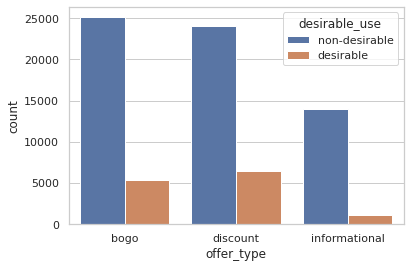

In [47]:
sns.countplot(data= total_offers_final, x= 'offer_type', hue = 'desirable_use', order = ['bogo', 'discount','informational'])

## 4.2 Analysis of Customer Value

    In this section, we explore the customer purchasing patterns using RFM Analysis. RFM refers to Recency, Frequency and Monetary values. This method analyses different customers on three major dimensions:

* How recently did the customer purchase?

* How often does the customer purchase?

* How much does the customer spend?

These metrics can be used in making predictions for different types of customers. We introcuce three additional features to the profile dataset to capture the three metrics  

In [48]:
# Quantification of recency of purchase

recency = transcript_transaction.groupby('customer_id', as_index= False)['days'].max()
recency['days'] = 120 - recency['days']
recency.rename(columns={'days':'recency'}, inplace = True)  
recency

,customer_id,recency
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,40
2,0011e0d4e6b944f998e987f904e8c1e5,10
3,0020c2b971eb4e9188eac86d93036a77,1
4,0020ccbbb6d84e358d3414a3ff76cffd,7
...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,27
16574,fff7576017104bcc8677a8d63322b5e1,3
16575,fff8957ea8b240a6b5e634b6ee8eafcf,23
16576,fffad4f4828548d1b5583907f2e9906b,6


In [49]:
# Quantification of purchase frequency 

frequency = transcript_transaction.groupby(['customer_id'], as_index= False)['amount'].count()
frequency.rename(columns={'amount':'frequency'}, inplace = True)
frequency

,customer_id,frequency
0,0009655768c64bdeb2e877511632db8f,8
1,00116118485d4dfda04fdbaba9a87b5c,3
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,8
4,0020ccbbb6d84e358d3414a3ff76cffd,12
...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,11
16574,fff7576017104bcc8677a8d63322b5e1,6
16575,fff8957ea8b240a6b5e634b6ee8eafcf,5
16576,fffad4f4828548d1b5583907f2e9906b,12


In [50]:
# Quantification of purchase amount

monetary = transcript_transaction.groupby('customer_id', as_index= False)['amount'].sum()
monetary.rename(columns={'amount':'monetary'}, inplace = True)   
monetary

,customer_id,monetary
0,0009655768c64bdeb2e877511632db8f,127.60000
1,00116118485d4dfda04fdbaba9a87b5c,4.09000
2,0011e0d4e6b944f998e987f904e8c1e5,79.46000
3,0020c2b971eb4e9188eac86d93036a77,196.86000
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05000
...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98000
16574,fff7576017104bcc8677a8d63322b5e1,29.94000
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15000
16576,fffad4f4828548d1b5583907f2e9906b,88.83000


In [51]:
# Merge the three info in a seperate dataset 

rfm = recency.merge(frequency, left_on = 'customer_id', right_on = 'customer_id', how = 'inner')
rfm = rfm.merge(monetary, left_on = 'customer_id', right_on = 'customer_id', how = 'inner')

print('The size of the RFM dataframe: ' , rfm.shape)
rfm.head(100)

The size of the RFM dataframe:  (16578, 4)


,customer_id,recency,frequency,monetary
0,0009655768c64bdeb2e877511632db8f,3,8,127.60000
1,00116118485d4dfda04fdbaba9a87b5c,40,3,4.09000
2,0011e0d4e6b944f998e987f904e8c1e5,10,5,79.46000
3,0020c2b971eb4e9188eac86d93036a77,1,8,196.86000
4,0020ccbbb6d84e358d3414a3ff76cffd,7,12,154.05000
5,003d66b6608740288d6cc97a6903f4f0,3,18,48.34000
6,00426fe3ffde4c6b9cb9ad6d077a13ea,3,17,68.51000
7,004b041fbfe44859945daa2c7f79ee64,0,6,138.36000
8,004c5799adbf42868b9cff0396190900,4,12,347.38000
9,005500a7188546ff8a767329a2f7c76a,21,4,20.36000


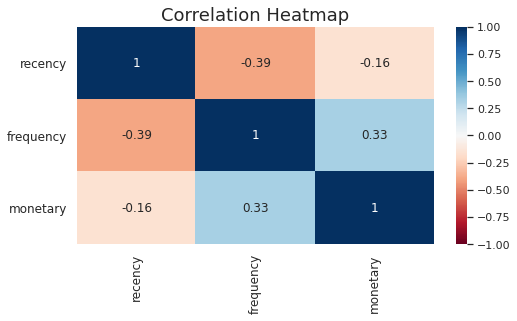

In [52]:
# Correlation in Heatmap form 
plt.figure(figsize=(8,4))
s = sns.heatmap(rfm.corr(), annot = True, cmap = 'RdBu', vmin = -1, vmax=1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize =12) 
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize =12) 
plt.title('Correlation Heatmap', fontsize =18)
plt.show()

From the correlation matrix above, we conclude that 

* recency is negatively correlated with frequency -- as customers with low recency value are more frequent 

* recency is negatively correlated with monetary -- customers with low rececncy value spend more amount in aggregate over the coffee expenditures

* frequency is positively correlated with monetary -- this is expected as more frequent customers spend more in aggregate over their coffee expenditures

## 4.3 Input dataset

In [106]:
# Create the input dataset by merging offer information, rfm and total_offers_final dataset

offers_summary = total_offers_final.merge(profile, left_on = 'customer_id', right_on ='customer_id', how='left')
offers_summary =offers_summary.merge(rfm, left_on = 'customer_id', right_on ='customer_id', how='left').fillna(0)
offers_summary.drop(['became_member_on','days','offer_expiry_day','offer_id'],axis =1, inplace= True)

In [107]:
offers_summary

,customer_id,offer_type,desirable_use,gender,age,income,days_as_member,recency,frequency,monetary
0,0009655768c64bdeb2e877511632db8f,informational,non-desirable,M,33,72000.00000,466,3.00000,8.00000,127.60000
1,0009655768c64bdeb2e877511632db8f,informational,non-desirable,M,33,72000.00000,466,3.00000,8.00000,127.60000
2,0009655768c64bdeb2e877511632db8f,bogo,non-desirable,M,33,72000.00000,466,3.00000,8.00000,127.60000
3,0009655768c64bdeb2e877511632db8f,discount,desirable,M,33,72000.00000,466,3.00000,8.00000,127.60000
4,0009655768c64bdeb2e877511632db8f,discount,non-desirable,M,33,72000.00000,466,3.00000,8.00000,127.60000
...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,discount,desirable,F,45,62000.00000,613,11.00000,15.00000,226.07000
76273,ffff82501cea40309d5fdd7edcca4a07,discount,non-desirable,F,45,62000.00000,613,11.00000,15.00000,226.07000
76274,ffff82501cea40309d5fdd7edcca4a07,discount,non-desirable,F,45,62000.00000,613,11.00000,15.00000,226.07000
76275,ffff82501cea40309d5fdd7edcca4a07,bogo,non-desirable,F,45,62000.00000,613,11.00000,15.00000,226.07000


<AxesSubplot:xlabel='offer_type', ylabel='count'>

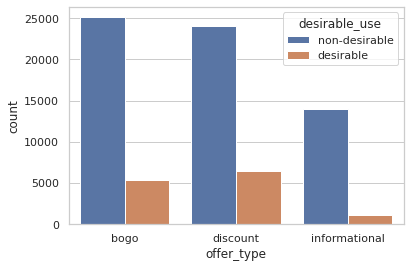

In [108]:
sns.countplot(data= offers_summary, x= 'offer_type', hue = 'desirable_use', order = ['bogo', 'discount','informational'])

From the chart above, we observe that the size of the 'informational' class is very low. Desirable 'informational' offers account for approx. 9% of the total desirable offers. 

# 5. Data Analysis

In this section, we perform the data analysis following the key steps:

* Data Splitting

* Setting up the Benchmark Model (Logistic Regression) for classification

* Setting up the SageMaker XGBoost Model

* Model perfromance evaluation and reasoning

* Adjustment of Model Inputs (e.g., removing model imbalance) and re-run of Step 2,3 and 4 

* Model Selection 

## 5.1 Data Splitting

Here we split the input dataset `offers_summary` into training and testing datasets. The model will train on the training dataset and will make predictions on the test dataset. We first seperate the `offers_summary` dataset by their offer types namely bogo, discount and informational.

The three subclasses will have their respective train and test datasets. This will help us infer if any dicount or bogo or informational offer will be desirable in the test dataset

In [109]:
# First we encode the desirable_use column which is the target variable

def encode(dset):
    dset['desirable_use'] = dset['desirable_use'].apply(lambda x: 1 if x=="desirable" else 0)
    return dset

encode(offers_summary)

,customer_id,offer_type,desirable_use,gender,age,income,days_as_member,recency,frequency,monetary
0,0009655768c64bdeb2e877511632db8f,informational,0,M,33,72000.00000,466,3.00000,8.00000,127.60000
1,0009655768c64bdeb2e877511632db8f,informational,0,M,33,72000.00000,466,3.00000,8.00000,127.60000
2,0009655768c64bdeb2e877511632db8f,bogo,0,M,33,72000.00000,466,3.00000,8.00000,127.60000
3,0009655768c64bdeb2e877511632db8f,discount,1,M,33,72000.00000,466,3.00000,8.00000,127.60000
4,0009655768c64bdeb2e877511632db8f,discount,0,M,33,72000.00000,466,3.00000,8.00000,127.60000
...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,discount,1,F,45,62000.00000,613,11.00000,15.00000,226.07000
76273,ffff82501cea40309d5fdd7edcca4a07,discount,0,F,45,62000.00000,613,11.00000,15.00000,226.07000
76274,ffff82501cea40309d5fdd7edcca4a07,discount,0,F,45,62000.00000,613,11.00000,15.00000,226.07000
76275,ffff82501cea40309d5fdd7edcca4a07,bogo,0,F,45,62000.00000,613,11.00000,15.00000,226.07000


In [110]:
test_size = 0.2
random_state = 42

offers_summary_bogo = offers_summary.query('offer_type == "bogo"')
offers_summary_discount = offers_summary.query('offer_type == "discount"')
offers_summary_informational = offers_summary.query('offer_type == "informational"')


bogo_target= offers_summary_bogo.desirable_use
discount_target= offers_summary_discount.desirable_use
informational_target= offers_summary_informational.desirable_use

In [111]:
offers_summary_bogo

,customer_id,offer_type,desirable_use,gender,age,income,days_as_member,recency,frequency,monetary
2,0009655768c64bdeb2e877511632db8f,bogo,0,M,33,72000.00000,466,3.00000,8.00000,127.60000
5,00116118485d4dfda04fdbaba9a87b5c,bogo,0,O,55,64000.00000,97,40.00000,3.00000,4.09000
6,00116118485d4dfda04fdbaba9a87b5c,bogo,0,O,55,64000.00000,97,40.00000,3.00000,4.09000
11,0011e0d4e6b944f998e987f904e8c1e5,bogo,0,O,40,57000.00000,203,10.00000,5.00000,79.46000
13,0020c2b971eb4e9188eac86d93036a77,bogo,0,F,59,90000.00000,879,1.00000,8.00000,196.86000
...,...,...,...,...,...,...,...,...,...,...
76266,fff8957ea8b240a6b5e634b6ee8eafcf,bogo,0,M,71,56000.00000,163,23.00000,5.00000,12.15000
76267,fffad4f4828548d1b5583907f2e9906b,bogo,0,M,34,34000.00000,554,6.00000,12.00000,88.83000
76269,fffad4f4828548d1b5583907f2e9906b,bogo,0,M,34,34000.00000,554,6.00000,12.00000,88.83000
76270,fffad4f4828548d1b5583907f2e9906b,bogo,0,M,34,34000.00000,554,6.00000,12.00000,88.83000


In [112]:
offers_summary_bogo.query('desirable_use == 0').shape[0]

25129

In [113]:
# Bogo
bogo_trainX, bogo_testX, bogo_trainy, bogo_testy = train_test_split(offers_summary_bogo, bogo_target, 
                                                                  test_size=test_size, random_state=random_state)
# Discount
discount_trainX, discount_testX, discount_trainy, discount_testy = train_test_split(offers_summary_discount, discount_target, 
                                                                    test_size=test_size, random_state=random_state)
# Informational
informational_trainX, informational_testX, informational_trainy, informational_testy = train_test_split(offers_summary_informational, informational_target, 
                                                                    test_size=test_size, random_state=random_state)

In [114]:
# Utility Function to examine the distributional composition of Train, Test Datasets

def split_summary(train, test):
    
    print("Training Dataset has "+ str(train.shape[0])+" observations ")
    print("Testing Dataset has "+ str(test.shape[0])+" observastions")
    
    pct = 100 * train.shape[0]/(train.shape[0]+test.shape[0])
    
    print("Split is "+str(pct)+" for train and "+str(100-pct) +" for test")
    
    d_train = train.query('desirable_use == 1').shape[0]
    nd_train = train.query('desirable_use == 0').shape[0]
    d_test = test.query('desirable_use == 1').shape[0]
    nd_test = test.query('desirable_use == 0').shape[0]
    
    print("The proportion of desirable class Training Dataset is "+str(100*d_train/(d_train+nd_train)))
    print("The proportion of desirable class Testing Dataset is "+str(100*d_test/(d_test+nd_test)))
    
    print('\n')

In [115]:
print("---Bogo Dataset summary---")
split_summary(bogo_trainX, bogo_testX)
print("---Discount Dataset summary---")
split_summary(discount_trainX, discount_testX)
print("---Informational Dataset summary---")
split_summary(informational_trainX, informational_testX)

---Bogo Dataset summary---
Training Dataset has 24399 observations 
Testing Dataset has 6100 observastions
Split is 79.99934424079478 for train and 20.000655759205216 for test
The proportion of desirable class Training Dataset is 17.58678634370261
The proportion of desirable class Testing Dataset is 17.688524590163933


---Discount Dataset summary---
Training Dataset has 24434 observations 
Testing Dataset has 6109 observastions
Split is 79.99869037095243 for train and 20.00130962904757 for test
The proportion of desirable class Training Dataset is 21.24498649422935
The proportion of desirable class Testing Dataset is 20.90358487477492


---Informational Dataset summary---
Training Dataset has 12188 observations 
Testing Dataset has 3047 observastions
Split is 80.0 for train and 20.0 for test
The proportion of desirable class Training Dataset is 7.745323268788972
The proportion of desirable class Testing Dataset is 7.975057433541188




From all the three datasets above, we conclude that the Training and Testing Dataset are both similarly distributed in the sense they have a similar composition of Target Variable.

To prepare these datasets for model training in further stages, we remove a few unecessary variables from the datasets. For each of the datasets, we make the following transformations:

* Drop the offer_type column since it has the same value for all three datasets

* Drop the customer_id column

* Convert the gender types into binary dummies

In [116]:
def prepare_dsets(train, test):
    train = pd.concat([train, pd.get_dummies(train.gender)], axis =1)
    train.drop(['customer_id', 'offer_type', 'gender'], axis = 1, inplace = True)
    test = pd.concat([test, pd.get_dummies(test.gender)], axis =1)
    test.drop(['customer_id', 'offer_type', 'gender', 'desirable_use'], axis = 1, inplace = True)
    return train, test

In [117]:
bogo_trainX, bogo_testX = prepare_dsets(bogo_trainX, bogo_testX)
discount_trainX, discount_testX = prepare_dsets(discount_trainX, discount_testX)
informational_trainX, informational_testX = prepare_dsets(informational_trainX, informational_testX)

## 5.3 Model Prediction and Performance Evaluation

In this section, we perform the Model fitting on training dataset and evaluation on test dataset. During the training, we also have a validation dtaset of 10% the size of Training dataset.

We will be using Logistic Regression Model as the benchmark model to evaluate other model predictions because this is a classification task.

The other model we will be using is **SageMaker XGBoost**. We have chosen XGBoost because of its Execution speed and Model Performance. XGBoost has faster execution when compared to other implementations of Gradient Boosting and generally has good performance on regression/classification tasks over tabular datasets.

We will follow the below generic implementation methdology for Sagemaker XGBoost:

* Obtain the best Hyperparameters using Hyperparameter Tuning

* Train the Model on Training Set

* Perform the fitting on Test Dataset and obtain the performance Metrics

Note that we are implementing Logistic Regression and its associated pipelines using sklearn library in Python due to limited available AWS Credits. 

Performance of the models is measured through the following ecaluation metrics:

* Accuracy

* Precision

* Recall

* F1 Score

## Benchmark Model - Logistic Regression

In [132]:
# Import Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier) 
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.metrics import precision_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score 
from time import time

In [133]:
logreg = LogisticRegression(random_state=42, class_weight = 'balanced')

In [134]:
def split_labels(dset):
    balanced_target= dset.desirable_use
    balanced_inputs= dset.drop(['desirable_use'], axis=1)
    return balanced_inputs, balanced_target

In [152]:
def logistic_regression(balanced_df, test_inputs, test_target, offer_type):
    
    results = pd.DataFrame(columns=['offer_type','accuracy','precision','recall','f1_score'])
    balanced_input, balanced_target = split_labels(balanced_df)
    logreg.fit(balanced_input , balanced_target)
    y_pred = logreg.predict(test_inputs)
    accuracy = np.mean( y_pred == test_target)
    precision = precision_score(test_target, y_pred, average= 'weighted', zero_division=0)
    recall = recall_score(test_target, y_pred, average= 'weighted', zero_division=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    results.loc["Logistic Regression"] = [offer_type, accuracy,precision, recall, f1_score]  
                
    return  pd.crosstab(test_target, y_pred, normalize='index'), results

In [136]:
bogo_conf, benchmark_bogo = logistic_regression(bogo_trainX, bogo_testX, bogo_testy, "bogo")
disc_conf, benchmark_discount = logistic_regression(discount_trainX, discount_testX, discount_testy, "discount")
info_conf, benchmark_info = logistic_regression(informational_trainX, informational_testX, informational_testy, "info")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [137]:
print('BOGO Confusion Matrix\n')
print(bogo_conf)
print('\n')
print('Discount Confusion Matrix\n')
print(disc_conf)
print('\n')
print('Informational Confusion Matrix\n')
print(info_conf)

BOGO Confusion Matrix

col_0               0       1
desirable_use                
0             0.65385 0.34615
1             0.39296 0.60704


Discount Confusion Matrix

col_0               0       1
desirable_use                
0             0.63245 0.36755
1             0.39154 0.60846


Informational Confusion Matrix

col_0               0       1
desirable_use                
0             0.63374 0.36626
1             0.38683 0.61317


In [138]:
benchmark_results = pd.concat([benchmark_bogo,benchmark_discount, benchmark_info], axis = 0)

In [139]:
benchmark_results

,offer_type,accuracy,precision,recall,f1_score
Logistic Regression,bogo,0.64557,0.77738,0.64557,0.70537
Logistic Regression,discount,0.62743,0.74337,0.62743,0.68050
Logistic Regression,info,0.63210,0.88412,0.63210,0.73716


## SageMaker XGBoost Model

In [3]:
import boto3
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import LinearLearner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput


from sagemaker import get_execution_role
session = sagemaker.Session()
role = get_execution_role()

bucket = session.default_bucket()

In [73]:
# First we upload the Training and Validation Datasets to s3 Bucket
# For SageMaker XGBoost, we require the first column to be the target variable and rest others to be inputs so the datasets
# need to be formatted accordingly. Also all entries must be numeric

def generate_trainval_dsets(dset):
    target = dset.desirable_use
    inputs = dset.drop('desirable_use', axis = 1)
    trainX_sub, trainX_valid, trainy_sub, trainy_valid = train_test_split(inputs, target, test_size=0.1)
    train = pd.concat([trainy_sub,trainX_sub], axis = 1)
    valid = pd.concat([trainy_valid,trainX_valid], axis = 1)
    return train, valid 

In [74]:
bogo_train, bogo_val = generate_trainval_dsets(bogo_trainX)
discount_train, discount_val = generate_trainval_dsets(discount_trainX)
info_train, info_val = generate_trainval_dsets(informational_trainX)

In [75]:
print("---Bogo Dataset summary---")
split_summary(bogo_train, bogo_val)
print("---Discount Dataset summary---")
split_summary(discount_train, discount_val)
print("---Informational Dataset summary---")
split_summary(info_train, info_val)

---Bogo Dataset summary---
Training Dataset has 21959 observations 
Testing Dataset has 2440 observastions
Split is 89.99959014713718 for train and 10.000409852862816 for test
The proportion of desirable class Training Dataset is 17.637415182840748
The proportion of desirable class Testing Dataset is 17.131147540983605


---Discount Dataset summary---
Training Dataset has 21990 observations 
Testing Dataset has 2444 observastions
Split is 89.99754440533682 for train and 10.002455594663175 for test
The proportion of desirable class Training Dataset is 21.277853569804456
The proportion of desirable class Testing Dataset is 20.949263502454993


---Informational Dataset summary---
Training Dataset has 10969 observations 
Testing Dataset has 1219 observastions
Split is 89.99835904168035 for train and 10.001640958319655 for test
The proportion of desirable class Training Dataset is 7.940559759321725
The proportion of desirable class Testing Dataset is 5.988515176374077




In [89]:
bogo_train.to_csv('bogo_train.csv', index = False, header = False)
bogo_val.to_csv('bogo_val.csv', index = False, header = False)

discount_train.to_csv('discount_train.csv', index = False, header = False)
discount_val.to_csv('discount_val.csv', index = False, header = False)

info_train.to_csv('info_train.csv', index = False, header = False)
info_val.to_csv('info_val.csv', index = False, header = False)

In [90]:
bogo_testX.to_csv('bogo_test.csv', index = False, header = False)
bogo_testy.to_csv('bogo_test_tgt.csv', index = False, header = False)

discount_testX.to_csv('discount_test.csv', index = False, header = False)
discount_testy.to_csv('discount_test_target.csv', index = False, header = False)

informational_testX.to_csv('info_test.csv', index = False, header = False)
informational_testy.to_csv('info_test_target.csv', index = False, header = False)

In [91]:
# Upload the Training and Validation sets to s3 bucket

inputs_bogo = session.upload_data(path="data/bogo", bucket=bucket, key_prefix = "Capstone_Starbucks/bogo")
inputs_discount = session.upload_data(path="data/discount", bucket=bucket, key_prefix = "Capstone_Starbucks/discount")
inputs_info = session.upload_data(path="data/info", bucket=bucket, key_prefix = "Capstone_Starbucks/info")

In [92]:
best_model = {'bogo': {}, 'discount': {}, 'info': {}}

In [93]:
# Set the model image
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['bogo', 'discount', 'info']:
    # Initialize XGBoost, with some hyperparameters
    xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.c4.xlarge',
                                        output_path=f's3://{bucket}/Capstone_Starbucks/{prefix}/model',
                                        sagemaker_session=session,
                                        base_job_name=prefix + '-')
    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1123)

    # Initialize tuner
    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                   objective_metric_name='validation:f1',
                                                   objective_type='Maximize',
                                                   max_jobs=20,
                                                   max_parallel_jobs=4,
                                                   hyperparameter_ranges = {
                                                        'max_depth': IntegerParameter(2, 6),
                                                        'eta'      : ContinuousParameter(0.01, 0.5),
                                                        'gamma': ContinuousParameter(0, 10),
                                                        'min_child_weight': IntegerParameter(2, 8),
                                                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                                                        'subsample': ContinuousParameter(0.3, 1.0),
                                                   },
                                                   base_tuning_job_name=prefix + '-xgb-tuning')

    # Take train and validation location in S3
    s3_input_train = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    # Fit tuner
    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    # Save results and best model
    best_model[prefix]['xgb'] = {'name': xgb_hyperparameter_tuner.best_training_job(),
                                 'value': xgb_hyperparameter_tuner.analytics().dataframe()['FinalObjectiveValue'].max()}

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


..................................................................................................................................................................................................................................................!
Waiting bogo...
!

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



........................................................................................................................................................................................................................................................!
Waiting discount...
!

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



.......................................................................................................................................................................................................................................!
Waiting info...
!


In [94]:
best_model

{'bogo': {'xgb': {'name': 'bogo-xgb-tuning-220402-0710-017-b0cd04df',
   'value': 0.4575900137424469}},
 'discount': {'xgb': {'name': 'discount-xgb-tuning-220402-0731-017-92ea1217',
   'value': 0.4776889979839325}},
 'info': {'xgb': {'name': 'info-xgb-tuning-220402-0752-001-e6d03aee',
   'value': 0.4799489974975586}}}

In [142]:
best_model['bogo']['xgb']['name']

'bogo-xgb-tuning-220402-0710-017-b0cd04df'

In [140]:
# Saving the best model for reuse in case the kernel dies
best_model = {'bogo': {'xgb': {'name': 'bogo-xgb-tuning-220402-0710-017-b0cd04df',
   'value': 0.4575900137424469}},
 'discount': {'xgb': {'name': 'discount-xgb-tuning-220402-0731-017-92ea1217',
   'value': 0.4776889979839325}},
 'info': {'xgb': {'name': 'info-xgb-tuning-220402-0752-001-e6d03aee',
   'value': 0.4799489974975586}}}

In [77]:
# Now we re-train the best model
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    tuner = sagemaker.estimator.Estimator.attach(best_model[prefix]['xgb']['name'])
    
    s3_input_train = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    best_model[prefix]['xgb']['model'] = tuner

bogo

2022-04-02 07:29:13 Starting - Preparing the instances for training
2022-04-02 07:29:13 Downloading - Downloading input data
2022-04-02 07:29:13 Training - Training image download completed. Training in progress.
2022-04-02 07:29:13 Uploading - Uploading generated training model
2022-04-02 07:29:13 Completed - Training job completed
2022-04-02 08:19:00 Starting - Starting the training job...
2022-04-02 08:19:25 Starting - Launching requested ML instancesProfilerReport-1648887540: InProgress
.........
2022-04-02 08:20:45 Starting - Preparing the instances for training......
2022-04-02 08:21:57 Downloading - Downloading input data...
2022-04-02 08:22:25 Training - Downloading the training image...
2022-04-02 08:22:56 Uploading - Uploading generated training model
2022-04-02 08:22:56 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric val


2022-04-02 08:30:21 Uploading - Uploading generated training model
2022-04-02 08:30:21 Completed - Training job completed
Training seconds: 88
Billable seconds: 88


In [78]:
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create XGB transformer
    transformer = best_model[prefix]['xgb']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', wait=True, logs=False)

    # Download data
    session.download_data(f'./data/{prefix}/{prefix}_xgb_preds', bucket,
                          key_prefix='/'.join(transformer.output_path.split('/')[3:]))


bogo
.......................................................................!
discount
.......................................................................!
info
.......................................................................!


In [9]:
from IPython.display import display

from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, average_precision_score, \
    roc_auc_score, roc_curve



def evaluate_model(y, y_prob, y_pred=None):
    
    """Given the truth labels and the model predictions (for a binary
    classification problem), this function provides a list of performance
    measures for a Machine Learning models. It also plots the ROC Curve and
    the Confusion/Classification Matrix.
    Parameters
    ----------
    y : list or numpy.array
        The ground truth labels
    y_prob : list or numpy.array
        Probabilities returned by the model
    y_pred : list or numpy.array, default None
        Predictions returned by the model. If None, these are calculated from
        y_prob with a 0.50 threshold
    Returns
    -------
    res : pandas.Datarame
        This dataset contains a list of the most used performance measures for
        the data provided
    """

    if y_pred is None:
        y_pred = pd.Series([1 if x >= 0.5 else 0 for x in y_prob])
        
    res = pd.DataFrame(
        {'value': [accuracy_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   precision_score(y, y_pred), recall_score(y, y_pred),
                   f1_score(y, y_pred),
                   average_precision_score(y, y_prob),
                   roc_auc_score(y, y_prob)]
         },
        index=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1',
               'average_precision', 'AUC']
    )

    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('FP')
    plt.ylabel('TPR')
    plt.show()
    print("Confusion Matrix")
    display(pd.crosstab(y, y_pred, normalize='index'))

    return res

bogo
XGBoost


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


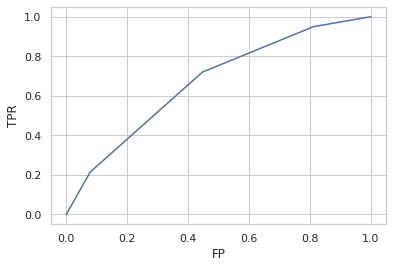

Confusion Matrix


col_0,0
0,
0,1.00000
1,1.00000


,value
accuracy,0.82311
balanced_accuracy,0.50000
precision,0.00000
recall,0.00000
f1,0.00000
average_precision,0.26416
AUC,0.66838





discount
XGBoost


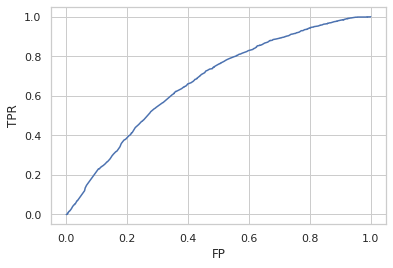

Confusion Matrix


col_0,0,1
0,,
0,0.99358,0.00642
1,0.99139,0.00861


,value
accuracy,0.78769
balanced_accuracy,0.50110
precision,0.26190
recall,0.00861
f1,0.01668
average_precision,0.31262
AUC,0.67243





info
XGBoost


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


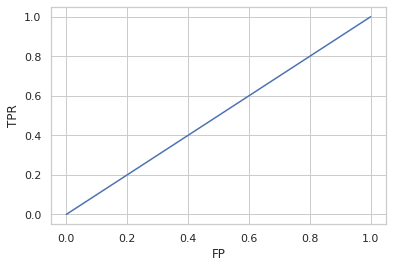

Confusion Matrix


col_0,0
0,
0,1.00000
1,1.00000


,value
accuracy,0.92025
balanced_accuracy,0.50000
precision,0.00000
recall,0.00000
f1,0.00000
average_precision,0.07975
AUC,0.50000


In [84]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    # Load ground truth
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_tgt.csv', squeeze=True, header=None)
    
    # XGBoost predictions
    print('XGBoost')
    y_prob = pd.read_csv(f'./data/{prefix}/{prefix}_xgb_preds/{prefix}_test.csv.out', squeeze=True, header=None)
    display(evaluate_model(y_test, y_prob))
    
    print('\n\n')

# Data Balancing

In [154]:
def Create_Balanced_dset(X_train, y_train): 
    
    train_nondesirables = int(collections.Counter(y_train)['non-desirable'])
    train_desirables = int(train_nondesirables*0.7)
    
    strategy = { 'non-desirable':train_nondesirables, 'desirable':train_desirables}
    oversample = SMOTE(sampling_strategy=strategy)
    
    X_balanced, y_balanced = oversample.fit_resample( X_train, y_train)
    
    
    balanced_train = pd.concat([y_balanced, X_balanced],axis=1)
    
    return balanced_train


In [155]:
offers_summary_bogo_2 = pd.concat([offers_summary_bogo, pd.get_dummies(offers_summary_bogo.gender)], axis =1)
offers_summary_discount_2 = pd.concat([offers_summary_discount, pd.get_dummies(offers_summary_discount.gender)], axis =1)
offers_summary_informational_2 = pd.concat([offers_summary_informational, pd.get_dummies(offers_summary_informational.gender)], axis =1)

offers_summary_bogo_2.drop(['customer_id', 'offer_type', 'gender'], axis=1, inplace = True)
offers_summary_discount_2.drop(['customer_id', 'offer_type', 'gender'], axis = 1, inplace = True)
offers_summary_informational_2.drop(['customer_id', 'offer_type', 'gender'], axis = 1, inplace = True)

In [156]:
offers_summary_bogo_2['desirable_use'] = offers_summary_bogo_2['desirable_use'].apply(lambda x: "desirable" if x==1 else "non-desirable")
offers_summary_discount_2['desirable_use'] = offers_summary_discount_2['desirable_use'].apply(lambda x: "desirable" if x==1 else "non-desirable")
offers_summary_informational_2['desirable_use'] = offers_summary_informational_2['desirable_use'].apply(lambda x: "desirable" if x==1 else "non-desirable")


In [157]:
offers_summary_bogo_2_y = offers_summary_bogo_2['desirable_use']
offers_summary_bogo_2_X = offers_summary_bogo_2.drop('desirable_use', axis =1)
offers_summary_discount_2_y = offers_summary_discount_2['desirable_use']
offers_summary_discount_2_X = offers_summary_discount_2.drop('desirable_use', axis =1)
offers_summary_informational_2_y = offers_summary_informational_2['desirable_use']
offers_summary_informational_2_X = offers_summary_informational_2.drop('desirable_use', axis =1)

In [158]:
balanced_bogo = Create_Balanced_dset(offers_summary_bogo_2_X, offers_summary_bogo_2_y)
balanced_discount = Create_Balanced_dset(offers_summary_discount_2_X, offers_summary_discount_2_y)
balanced_info = Create_Balanced_dset(offers_summary_informational_2_X, offers_summary_informational_2_y)

In [159]:
balanced_bogo['desirable_use'] = balanced_bogo['desirable_use'].apply(lambda x: 1 if x=="desirable" else 0)
balanced_discount['desirable_use'] = balanced_discount['desirable_use'].apply(lambda x: 1 if x=="desirable" else 0)
balanced_info['desirable_use'] = balanced_info['desirable_use'].apply(lambda x: 1 if x=="desirable" else 0)


In [160]:
# Bogo
bogo_trainX_balanced, bogo_testX_balanced, bogo_trainy_balanced, bogo_testy_balanced = train_test_split(balanced_bogo, balanced_bogo.desirable_use, 
                                                                  test_size=test_size, random_state=random_state)
# Discount
discount_trainX_balanced, discount_testX_balanced, discount_trainy_balanced, discount_testy_balanced = train_test_split(balanced_discount, balanced_discount.desirable_use, 
                                                                    test_size=test_size, random_state=random_state)
# Informational
informational_trainX_balanced, informational_testX_balanced, informational_trainy_balanced, informational_testy_balanced = train_test_split(balanced_info, balanced_info.desirable_use, 
                                                                    test_size=test_size, random_state=random_state)

In [161]:
print("---Bogo Dataset summary---")
split_summary(bogo_trainX_balanced, bogo_testX_balanced)
print("---Discount Dataset summary---")
split_summary(discount_trainX_balanced, discount_testX_balanced)
print("---Informational Dataset summary---")
split_summary(informational_trainX_balanced, informational_testX_balanced)

---Bogo Dataset summary---
Training Dataset has 34175 observations 
Testing Dataset has 8544 observastions
Split is 79.99953182424682 for train and 20.000468175753184 for test
The proportion of desirable class Training Dataset is 41.34601316752012
The proportion of desirable class Testing Dataset is 40.49625468164794


---Discount Dataset summary---
Training Dataset has 32741 observations 
Testing Dataset has 8186 observastions
Split is 79.99853397512645 for train and 20.00146602487355 for test
The proportion of desirable class Training Dataset is 41.09526282031703
The proportion of desirable class Testing Dataset is 41.497678964085026


---Informational Dataset summary---
Training Dataset has 19104 observations 
Testing Dataset has 4777 observastions
Split is 79.9966500565303 for train and 20.0033499434697 for test
The proportion of desirable class Training Dataset is 41.16938860971524
The proportion of desirable class Testing Dataset is 41.19740422859535




In [162]:
bogo_testX_balanced = bogo_testX_balanced.drop('desirable_use', axis = 1)
discount_testX_balanced = discount_testX_balanced.drop('desirable_use', axis = 1)
informational_testX_balanced = informational_testX_balanced.drop('desirable_use', axis = 1)


bogo_bal_conf, benchmark_bogo_balanced = logistic_regression(bogo_trainX_balanced, bogo_testX_balanced, bogo_testy_balanced, "bogo_balanced")
discount_bal_conf, benchmark_discount_balanced = logistic_regression(discount_trainX_balanced, discount_testX_balanced, discount_testy_balanced, "discount_balanced")
info_bal_conf, benchmark_info_balanced = logistic_regression(informational_trainX_balanced, informational_testX_balanced, informational_testy_balanced, "info_balanced")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [163]:
benchmark_results_balanced = pd.concat([benchmark_bogo_balanced,benchmark_discount_balanced, benchmark_info_balanced], axis = 0)

In [166]:
print('BOGO Confusion Matrix\n')
print(bogo_bal_conf)
print('\n')
print('Discount Confusion Matrix\n')
print(discount_bal_conf)
print('\n')
print('Informational Confusion Matrix\n')
print(info_bal_conf)

BOGO Confusion Matrix

col_0               0       1
desirable_use                
0             0.64162 0.35838
1             0.37023 0.62977


Discount Confusion Matrix

col_0               0       1
desirable_use                
0             0.57883 0.42117
1             0.36856 0.63144


Informational Confusion Matrix

col_0               0       1
desirable_use                
0             0.63937 0.36063
1             0.45122 0.54878


In [164]:
benchmark_results_balanced

,offer_type,accuracy,precision,recall,f1_score
Logistic Regression,bogo_balanced,0.63682,0.64780,0.63682,0.64226
Logistic Regression,discount_balanced,0.60066,0.61687,0.60066,0.60866
Logistic Regression,info_balanced,0.60205,0.60606,0.60205,0.60405


In [96]:
bogo_train_balanced, bogo_val_balanced = generate_trainval_dsets(bogo_trainX_balanced)
discount_train_balanced, discount_val_balanced = generate_trainval_dsets(discount_trainX_balanced)
info_train_balanced, info_val_balanced = generate_trainval_dsets(informational_trainX_balanced)

In [97]:
print("---Bogo Dataset summary---")
split_summary(bogo_train_balanced, bogo_val_balanced)
print("---Discount Dataset summary---")
split_summary(discount_train_balanced, discount_val_balanced)
print("---Informational Dataset summary---")
split_summary(info_train_balanced, info_val_balanced)

---Bogo Dataset summary---
Training Dataset has 30757 observations 
Testing Dataset has 3418 observastions
Split is 89.99853694220921 for train and 10.001463057790787 for test
The proportion of desirable class Training Dataset is 41.29791592157883
The proportion of desirable class Testing Dataset is 41.77881802223523


---Discount Dataset summary---
Training Dataset has 29466 observations 
Testing Dataset has 3275 observastions
Split is 89.99725115298861 for train and 10.00274884701139 for test
The proportion of desirable class Training Dataset is 40.972646439964706
The proportion of desirable class Testing Dataset is 42.19847328244275


---Informational Dataset summary---
Training Dataset has 17193 observations 
Testing Dataset has 1911 observastions
Split is 89.99685929648241 for train and 10.003140703517587 for test
The proportion of desirable class Training Dataset is 41.144651893212355
The proportion of desirable class Testing Dataset is 41.391941391941394




In [98]:
bogo_train_balanced.to_csv('bogo_train_balanced.csv', index = False, header = False)
bogo_val_balanced.to_csv('bogo_val_balanced.csv', index = False, header = False)

discount_train_balanced.to_csv('discount_train_balanced.csv', index = False, header = False)
discount_val_balanced.to_csv('discount_val_balanced.csv', index = False, header = False)

info_train_balanced.to_csv('info_train_balanced.csv', index = False, header = False)
info_val_balanced.to_csv('info_val_balanced.csv', index = False, header = False)

In [99]:
bogo_testX.to_csv('bogo_test_balanced.csv', index = False, header = False)
bogo_testy.to_csv('bogo_test_tgt_balanced.csv', index = False, header = False)

discount_testX.to_csv('discount_test_balanced.csv', index = False, header = False)
discount_testy.to_csv('discount_test_tgt_balanced.csv', index = False, header = False)

informational_testX.to_csv('info_test_balanced.csv', index = False, header = False)
informational_testy.to_csv('info_test_tgt_balanced.csv', index = False, header = False)

In [103]:
# Upload the Training and Validation sets to s3 bucket

inputs_bogo = session.upload_data(path="data/bogo", bucket=bucket, key_prefix = "Capstone_Starbucks/bogo")
inputs_discount = session.upload_data(path="data/discount", bucket=bucket, key_prefix = "Capstone_Starbucks/discount")
inputs_info = session.upload_data(path="data/info", bucket=bucket, key_prefix = "Capstone_Starbucks/info")

In [104]:
best_model_balanced = {'bogo': {}, 'discount': {}, 'info': {}}

In [ ]:
# Set the model image
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['bogo', 'discount', 'info']:
    # Initialize XGBoost, with some hyperparameters
    xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.c4.xlarge',
                                        output_path=f's3://{bucket}/Capstone_Starbucks/{prefix}/model',
                                        sagemaker_session=session,
                                        base_job_name=prefix + '-')
    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1123)

    # Initialize tuner
    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                   objective_metric_name='validation:f1',
                                                   objective_type='Maximize',
                                                   max_jobs=20,
                                                   max_parallel_jobs=4,
                                                   hyperparameter_ranges = {
                                                        'max_depth': IntegerParameter(2, 6),
                                                        'eta'      : ContinuousParameter(0.01, 0.5),
                                                        'gamma': ContinuousParameter(0, 10),
                                                        'min_child_weight': IntegerParameter(2, 8),
                                                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                                                        'subsample': ContinuousParameter(0.3, 1.0),
                                                   },
                                                   base_tuning_job_name=prefix + '-xgb-tuning')

    # Take train and validation location in S3
    s3_input_train = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train_balanced.csv', content_type='csv')
    s3_input_validation = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val_balanced.csv', content_type='csv')

    # Fit tuner
    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    # Save results and best model
    best_model_balanced[prefix]['xgb'] = {'name': xgb_hyperparameter_tuner.best_training_job(),
                                 'value': xgb_hyperparameter_tuner.analytics().dataframe()['FinalObjectiveValue'].max()}

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


..........................................................................................................................................................................................................................................!
Waiting bogo...
!


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


.......................................................................................................................................................................................................!
Waiting info...
!


In [107]:
best_model_balanced

{'bogo': {'xgb': {'name': 'bogo-xgb-tuning-220402-0908-015-01024899',
   'value': 0.8159499764442444}},
 'discount': {'xgb': {'name': 'discount-xgb-tuning-220402-0928-020-2937d22f',
   'value': 0.7795050144195557}},
 'info': {'xgb': {'name': 'info-xgb-tuning-220402-0948-017-0540f11c',
   'value': 0.9277939796447754}}}

In [108]:
best_model_balanced = {'bogo': {'xgb': {'name': 'bogo-xgb-tuning-220402-0908-015-01024899',
   'value': 0.8159499764442444}},
 'discount': {'xgb': {'name': 'discount-xgb-tuning-220402-0928-020-2937d22f',
   'value': 0.7795050144195557}},
 'info': {'xgb': {'name': 'info-xgb-tuning-220402-0948-017-0540f11c',
   'value': 0.9277939796447754}}}

In [109]:
# Now we re-train the best model
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    tuner = sagemaker.estimator.Estimator.attach(best_model_balanced[prefix]['xgb']['name'])
    
    s3_input_train = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train_balanced.csv', content_type='csv')
    s3_input_validation = sagemaker.TrainingInput(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val_balanced.csv', content_type='csv')

    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    best_model_balanced[prefix]['xgb']['model'] = tuner

bogo

2022-04-02 09:23:47 Starting - Preparing the instances for training
2022-04-02 09:23:47 Downloading - Downloading input data
2022-04-02 09:23:47 Training - Training image download completed. Training in progress.
2022-04-02 09:23:47 Uploading - Uploading generated training model
2022-04-02 09:23:47 Completed - Training job completed
2022-04-02 10:09:01 Starting - Starting the training job...ProfilerReport-1648894141: InProgress
...
2022-04-02 10:09:53 Starting - Preparing the instances for training......
2022-04-02 10:10:54 Downloading - Downloading input data......
2022-04-02 10:11:54 Training - Downloading the training image...
2022-04-02 10:12:31 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installe


2022-04-02 10:21:00 Completed - Training job completed
Training seconds: 93
Billable seconds: 93


In [110]:
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create XGB transformer
    transformer = best_model_balanced[prefix]['xgb']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test_balanced.csv',
                                       content_type='text/csv', split_type='Line', wait=True, logs=False)

    # Download data
    session.download_data(f'./data/{prefix}/{prefix}_xgb_preds', bucket,
                          key_prefix='/'.join(transformer.output_path.split('/')[3:]))


bogo
....................................................................!
discount
.....................................................................!
info
......................................................................!


bogo
XGBoost


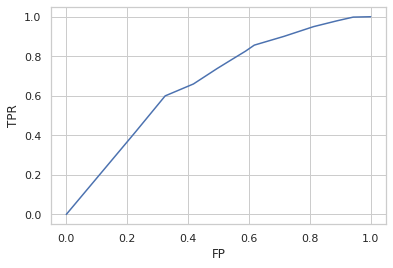

Confusion Matrix


col_0,0,1
0,,
0,0.77176,0.22824
1,0.58109,0.41891


,value
accuracy,0.70934
balanced_accuracy,0.59533
precision,0.28285
recall,0.41891
f1,0.33769
average_precision,0.26038
AUC,0.66696





discount
XGBoost


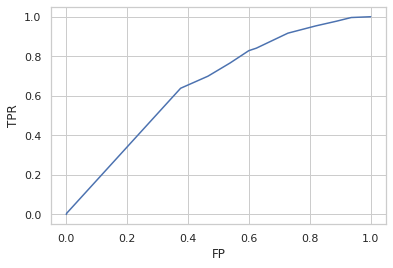

Confusion Matrix


col_0,0,1
0,,
0,0.62438,0.37562
1,0.36179,0.63821


,value
accuracy,0.62727
balanced_accuracy,0.63130
precision,0.30989
recall,0.63821
f1,0.41720
average_precision,0.29265
AUC,0.65762





info
XGBoost


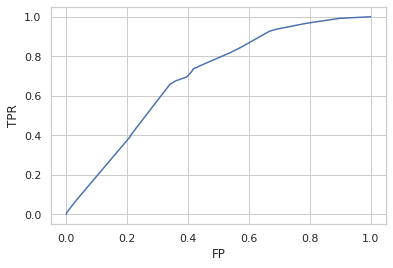

Confusion Matrix


col_0,0,1
0,,
0,0.96576,0.03424
1,0.92593,0.07407


,value
accuracy,0.89465
balanced_accuracy,0.51992
precision,0.15789
recall,0.07407
f1,0.10084
average_precision,0.13490
AUC,0.69445


In [111]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    # Load ground truth
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_tgt_balanced.csv', squeeze=True, header=None)
    
    # XGBoost predictions
    print('XGBoost')
    y_prob = pd.read_csv(f'./data/{prefix}/{prefix}_xgb_preds/{prefix}_test_balanced.csv.out', squeeze=True, header=None)
    display(evaluate_model(y_test, y_prob))
    
    print('\n\n')

# Linear Learner

In [4]:
best_model_balanced_ll = {'bogo': {}, 'discount': {}, 'info': {}}

In [6]:
for prefix in ['bogo', 'discount', 'info']:
    # Create instance of LinearLearner
    ll = LinearLearner(role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path='s3://{}/Capstone_Starbucks/{}/model'.format(bucket, prefix),
                       sagemaker_session=session,
                       binary_classifier_model_selection_criteria='f1',
                       epochs=100,
                       use_bias=True,
                       optimizer='adam',
                       loss='auto',
                       wd=0,
                       normalize_data=True,
                       unbias_data=True,
                       early_stopping_patience=5,
                       learning_rate=0.01,
                       balance_multiclass_weights=True)
    
    # Create record sets from local data as inputs to the LinearLearner
    train = pd.read_csv(f'./data/{prefix}/{prefix}_train_balanced.csv', header=None)
    train_data = ll.record_set(train.drop(0, 1).values.astype('float32'), labels=train[0].values.astype('float32'),
                                         channel='train')
    
    valid = pd.read_csv(f'./data/{prefix}/{prefix}_val_balanced.csv', header=None)
    validation_data = ll.record_set(valid.drop(0, 1).values.astype('float32'), labels=valid[0].values.astype('float32'),
                                         channel='validation')

    # Fit the model
    ll.fit([train_data, validation_data], logs=False)

    # Save results
    tja = ll.training_job_analytics
    res = tja.dataframe()
    best_model_balanced_ll[prefix]['ll'] = {'name': tja.name,
                                'value': res.loc[res['metric_name'] == 'validation:binary_f_beta', 'value'].values[0],
                                'model': ll}

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2022-04-02 16:34:26 Starting - Starting the training job.....
2022-04-02 16:34:55 Starting - Preparing the instances for training............................................................................................................................
2022-04-02 16:45:21 Starting - Launched instance was unhealthy, replacing it!.
2022-04-02 16:45:34 Starting - Preparing the instances for training..............
2022-04-02 16:46:49 Downloading - Downloading input data....
2022-04-02 16:47:15 Training - Downloading the training image.........
2022-04-02 16:48:00 Training - Training image download completed. Training in progress.......................................
2022-04-02 16:51:17 Uploading - Uploading generated training model.
2022-04-02 16:51:27 Completed - Training job completed

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2022-04-02 16:51:33 Starting - Starting the training job......
2022-04-02 16:52:05 Starting - Preparing the instances for training..................
2022-04-02 16:53:43 Downloading - Downloading input data.........
2022-04-02 16:54:32 Training - Training image download completed. Training in progress........................................
2022-04-02 16:57:53 Uploading - Uploading generated training model.
2022-04-02 16:58:04 Completed - Training job completed

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2022-04-02 16:58:07 Starting - Starting the training job......
2022-04-02 16:58:37 Starting - Preparing the instances for training................
2022-04-02 17:00:06 Downloading - Downloading input data..........
2022-04-02 17:01:02 Training - Training image download completed. Training in progress.............................
2022-04-02 17:03:29 Uploading - Uploading generated training model..
2022-04-02 17:03:39 Completed - Training job completed

In [7]:
best_model_balanced_ll

{'bogo': {'ll': {'name': 'linear-learner-2022-04-02-16-34-26-079',
   'value': 0.6724090025006947,
   'model': <sagemaker.amazon.linear_learner.LinearLearner at 0x7f817fceec50>}},
 'discount': {'ll': {'name': 'linear-learner-2022-04-02-16-51-33-502',
   'value': 0.6550079491255962,
   'model': <sagemaker.amazon.linear_learner.LinearLearner at 0x7f81800c6630>}},
 'info': {'ll': {'name': 'linear-learner-2022-04-02-16-58-07-120',
   'value': 0.7075688073394495,
   'model': <sagemaker.amazon.linear_learner.LinearLearner at 0x7f81b615d4a8>}}}

In [8]:
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create LL transformer
    transformer = best_model_balanced_ll[prefix]['ll']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test_balanced.csv',
                                       content_type='text/csv', split_type='Line', logs=False)
    
    transformer.wait(logs=False)
    
    # Download data
    session.download_data(f'./data/{prefix}/{prefix}_ll_preds', bucket,
                          key_prefix='/'.join(transformer.output_path.split('/')[3:]))
    

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


bogo
...................................................................!
!


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


discount
.....................................................................!
!
info


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


......................................................................!
!


bogo
LinearLearner


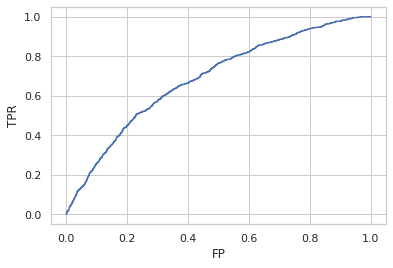

Confusion Matrix


col_0,0,1
0,,
0,0.51723,0.48277
1,0.25579,0.74421


,value
accuracy,0.55738
balanced_accuracy,0.63072
precision,0.24884
recall,0.74421
f1,0.37297
average_precision,0.30569
AUC,0.68635





discount
LinearLearner


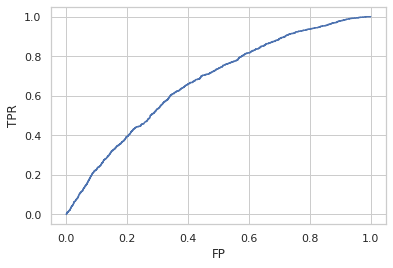

Confusion Matrix


col_0,0,1
0,,
0,0.61031,0.38969
1,0.35161,0.64839


,value
accuracy,0.61827
balanced_accuracy,0.62935
precision,0.30542
recall,0.64839
f1,0.41525
average_precision,0.32182
AUC,0.66928





info
LinearLearner


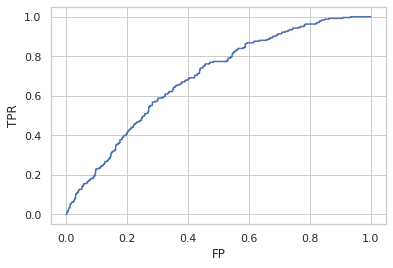

Confusion Matrix


col_0,0,1
0,,
0,0.68010,0.31990
1,0.40329,0.59671


,value
accuracy,0.67345
balanced_accuracy,0.63840
precision,0.13916
recall,0.59671
f1,0.22568
average_precision,0.14831
AUC,0.69181


In [11]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    # Load ground truth
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_tgt_balanced.csv', squeeze=True, header=None)
    

    # LinearLearner predictions
    print('LinearLearner')
    with open(f'./data/{prefix}/{prefix}_ll_preds/{prefix}_test_balanced.csv.out', 'r') as f:
        jsons = [json.loads(x.replace('\n', '')) for x in f.readlines()]
    res = pd.DataFrame(jsons)
    display(evaluate_model(y_test, res['score'].values, y_pred=res['predicted_label'].values))
    
    print('\n\n')